<a href="https://colab.research.google.com/github/EmelineBou/Projet_ArcPy/blob/main/Projet_ArcPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carte des tsunamis dévastateurs de 2004 et 2011
L'objectif de ce projet est de réaliser une carte présentant deux tsunamis dévastateurs (celui de 2004 et celui de 2011, tout deux de magnitude 9,1) avec leurs rayons d'impact, les pays touchés et les différentes informations concernant ces pays (nombre de morts, dégâts matériels...).

In [1]:
!pip install geodatasets
!pip install folium==0.14.0
!pip install geopandas
!pip install requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: folium
    Found existing installation: folium 0.19.4
    Uninstalling folium-0.19.4:
      Successfully uninstalled folium-0.19.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geemap 0.35.1 requires folium>=0.17.0, but you have folium 0.14.0 which is incompatible.


#1. Récupération des données et création de la carte

In [2]:
import pandas as pd
import geopandas as gpd

# Récupération des données des séismes
df = pd.read_csv("https://raw.githubusercontent.com/EmelineBou/Projet_ArcPy/refs/heads/main/Geophysical_data.csv", sep=';', encoding='utf-8')

In [3]:
# Les latitudes et longitudes ont des virgules au lieu de points, il faut le corriger
df['Longitude'] = df['Longitude'].str.replace(',', '.').astype(float)
df['Latitude'] = df['Latitude'].str.replace(',', '.').astype(float)

# Remplacer les virgules par des points dans la colonne 'Magnitude'
df['Magnitude'] = df['Magnitude'].str.replace(',', '.')

# Convertir la colonne 'Magnitude' en float
df['Magnitude'] = df['Magnitude'].astype(float)

On commence par isoler les tsunamis correspondant aux évènement du 26/12/2004 et du 11/03/2011

In [4]:
# Filtrage des tsunamis pour les dates spécifiques
info_degats_2004 = df[
    ((df['Disaster Subtype'] == 'Tsunami')) & ((df['Start Year'] == 2004) & (df['Start Month'] == 12) & (df['Start Day'] == 26))
]

info_degats_2011 = df[
    ((df['Disaster Subtype'] == 'Tsunami')) & ((df['Start Year'] == 2011) & (df['Start Month'] == 3) & (df['Start Day'] == 11))
]

# Affichage des résultats filtrés
info_degats_2004

DisNo. Historic Classification Key Disaster Group  \
185  2004-0659-BGD       No    nat-geo-ear-tsu        Natural   
186  2004-0659-IDN       No    nat-geo-ear-tsu        Natural   
187  2004-0659-IND       No    nat-geo-ear-tsu        Natural   
188  2004-0659-KEN       No    nat-geo-ear-tsu        Natural   
189  2004-0659-LKA       No    nat-geo-ear-tsu        Natural   
190  2004-0659-MDV       No    nat-geo-ear-tsu        Natural   
191  2004-0659-MMR       No    nat-geo-ear-tsu        Natural   
192  2004-0659-MYS       No    nat-geo-ear-tsu        Natural   
193  2004-0659-SOM       No    nat-geo-ear-tsu        Natural   
194  2004-0659-SYC       No    nat-geo-ear-tsu        Natural   
195  2004-0659-THA       No    nat-geo-ear-tsu        Natural   
196  2004-0659-TZA       No    nat-geo-ear-tsu        Natural   

    Disaster Subgroup Disaster Type Disaster Subtype External IDs Event Name  \
185       Geophysical    Earthquake          Tsunami          NaN        NaN   
186       Geophysical    Earthquake          Tsunami          NaN        NaN   
187       Geophysical    Earthquake          Tsunami          NaN        NaN   
188       Geophysical    Earthquake          Tsunami          NaN        NaN   
189       Geophysical    Earthquake          Tsunami          NaN        NaN   
190       Geophysical    Earthquake          Tsunami          NaN        NaN   
191       Geophysical    Earthquake          Tsunami          NaN        NaN   
192       Geophysical    Earthquake          Tsunami          NaN        NaN   
193       Geophysical    Earthquake          Tsunami          NaN        NaN   
194       Geophysical    Earthquake          Tsunami          NaN        NaN   
195       Geophysical    Earthquake          Tsunami          NaN        NaN   
196       Geophysical    Earthquake          Tsunami          NaN        NaN   

     ISO  ... Reconstruction Costs ('000 US$)  \
185  BGD  ...                             NaN   
186  IDN  ...                             NaN   
187  IND  ...                             NaN   
188  KEN  ...                             NaN   
189  LKA  ...                             NaN   
190  MDV  ...                             NaN   
191  MMR  ...                             NaN   
192  MYS  ...                             NaN   
193  SOM  ...                             NaN   
194  SYC  ...                             NaN   
195  THA  ...                             NaN   
196  TZA  ...                             NaN   

    Reconstruction Costs, Adjusted ('000 US$) Insured Damage ('000 US$)  \
185                                       NaN                       NaN   
186                                       NaN                  225000.0   
187                                       NaN                    5000.0   
188                                       NaN                       NaN   
189                                       NaN                       NaN   
190                                       NaN                       NaN   
191                                       NaN                       NaN   
192                                       NaN                       NaN   
193                                       NaN                       NaN   
194                                       NaN                       NaN   
195                                       NaN                  250000.0   
196                                       NaN                       NaN   

    Insured Damage, Adjusted ('000 US$) Total Damage ('000 US$)  \
185                                 NaN                500000.0   
186                            362964.0               4451600.0   
187                              8066.0               1022800.0   
188                                 NaN                100000.0   
189                                 NaN               1316500.0   
190                                 NaN                470100.0   
191                                 NaN   

Plusieurs pays sont enregistrés pour le même séisme. L'objectif est d'obtenir une seule ligne par tsunami cumulant le informations sur les dégâts, le coût des réparations et autre afin d'obtenir des informations globales. Ce fichier permettra ensuite de visualiser les tsunamis.

In [5]:
# Colonnes à additionner et à garder
columns_to_sum = [
    "Total Deaths",
    "No. Injured",
    "No. Affected",
    "No. Homeless",
    "Total Affected",
    "Reconstruction Costs ('000 US$)",
    "Reconstruction Costs, Adjusted ('000 US$)",
    "Insured Damage ('000 US$)",
    "Insured Damage, Adjusted ('000 US$)",
    "Total Damage ('000 US$)",
    "Total Damage, Adjusted ('000 US$)"
]

columns_to_keep = [
    'Longitude',
    'Latitude',
    "Disaster Group",
    "Disaster Subgroup",
    "Disaster Type",
    "Disaster Subtype",
    "Associated Types"
]

# Grouper les valeurs afin d'obtenir une somme des dégâts et des coûts pour les deux séismes
tsunami_2004 = info_degats_2004.groupby(['Disaster Subtype', 'Start Year', 'Start Month', 'Start Day', 'Magnitude'], as_index=False).agg(
    {
        **{col: 'first' for col in columns_to_keep},  # Garder la première valeur pour les colonnes textuelles
        **{col: 'sum' for col in columns_to_sum},  # Additionner les colonnes numériques
    }
)

tsunami_2011 = info_degats_2011.groupby(['Disaster Subtype', 'Start Year', 'Start Month', 'Start Day', 'Magnitude'], as_index=False).agg(
    {
        **{col: 'first' for col in columns_to_keep},  # Garder la première valeur pour les colonnes textuelles
        **{col: 'sum' for col in columns_to_sum},  # Additionner les colonnes numériques
    }
)

# Fusionner les deux DataFrames
merged_tsunamis = pd.concat([tsunami_2004, tsunami_2011], ignore_index=True)

# Afficher le résultat
merged_tsunamis

Start Year  Start Month  Start Day  Magnitude  Longitude  Latitude  \
0        2004           12       26.0        9.1     95.982     3.295   
1        2011            3       11.0        9.1    142.373    38.297   

  Disaster Group Disaster Subgroup Disaster Type Disaster Subtype  ...  \
0        Natural       Geophysical    Earthquake          Tsunami  ...   
1        Natural       Geophysical    Earthquake          Tsunami  ...   

  No. Injured  No. Affected  No. Homeless  Total Affected  \
0     41810.0     1356339.0     1033464.0       2431613.0   
1      5933.0      362887.0          95.0        368915.0   

   Reconstruction Costs ('000 US$)  Reconstruction Costs, Adjusted ('000 US$)  \
0                              0.0                                        0.0   
1                              0.0                                        0.0   

   Insured Damage ('000 US$)  Insured Damage, Adjusted ('000 US$)  \
0                   480000.0                             774324.0   
1                 37500000.0                           50797348.0   

   Total Damage ('000 US$)  Total Damage, Adjusted ('000 US$)  
0                9991000.0                         16117222.0  
1              210000000.0                        284465151.0  

[2 rows x 22 columns]

In [6]:
# Convertir en GeoDataFrame avec des points
tsunamis_gdf = gpd.GeoDataFrame(
    merged_tsunamis,
    geometry=gpd.points_from_xy(merged_tsunamis.Longitude, merged_tsunamis.Latitude)
)

Le fichier avec les points étant prêts, nous allons maintenant les afficher sur une carte.

In [7]:
# Installation du module permettant d'afficher la carte
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.2 MB/s eta 0:00:00


In [8]:
# Définition du systeme de coordonnées (WGS84)
tsunamis_gdf.set_crs(epsg=4326, inplace=True)

Start Year  Start Month  Start Day  Magnitude  Longitude  Latitude  \
0        2004           12       26.0        9.1     95.982     3.295   
1        2011            3       11.0        9.1    142.373    38.297   

  Disaster Group Disaster Subgroup Disaster Type Disaster Subtype  ...  \
0        Natural       Geophysical    Earthquake          Tsunami  ...   
1        Natural       Geophysical    Earthquake          Tsunami  ...   

  No. Affected  No. Homeless  Total Affected  Reconstruction Costs ('000 US$)  \
0    1356339.0     1033464.0       2431613.0                              0.0   
1     362887.0          95.0        368915.0                              0.0   

   Reconstruction Costs, Adjusted ('000 US$)  Insured Damage ('000 US$)  \
0                                        0.0                   480000.0   
1                                        0.0                 37500000.0   

   Insured Damage, Adjusted ('000 US$)  Total Damage ('000 US$)  \
0                             774324.0                9991000.0   
1                           50797348.0              210000000.0   

   Total Damage, Adjusted ('000 US$)                geometry  
0                         16117222.0    POINT (95.982 3.295)  
1                        284465151.0  POINT (142.373 38.297)  

[2 rows x 23 columns]

In [9]:
# Visualisation des points sur la carte
map = tsunamis_gdf.explore()
map

# 2. Modélisation du rayon d'impact des tsunamis
Pour cela, nous allons modéliser le rayon d'action du tsunami sous la forme d'un cercle, allant jusqu'aux derniers pays touchés (le rayon d'action est basé sur des articles lus en ligne relatant les évènements). Le cercle ne sera visible que sur les océans (un tsunami ne se déplaçant pas sur terre)

Modélisation du rayon d'impact du séisme ayant causé le tsunami (ce cercle est également visible sur la terre)

In [10]:
import folium
from folium import Map
from folium.plugins import FloatImage
from matplotlib import cm, colors
import requests
from shapely.geometry import Point, Polygon
from shapely.ops import transform
import pyproj

# Fonction pour calculer l'emprise en fonction de la magnitude
def calculate_emprise(magnitude):
    # On applique une règle de 3 pour définir la taille d'emprise d'un tsunami,
    # sachant que 6,1 de magnitude donne une emprise de 100km et que 9 de magnitude donne une emprise de 1000km
    # /!\ ces grandeurs sont valables pour tous les séismes et non uniquement pour les tsunamis
    return 100 + (magnitude - 6.1) * (1000 - 100) / (9 - 6.1)

# Liste pour stocker les polygones des tsunamis
seisme_polygons = []

# Ajout des polygones des séismes sur la carte
for _, row in tsunamis_gdf.iterrows():
    magnitude = row['Magnitude']
    emprise = calculate_emprise(magnitude)  # Calcul de l'emprise en km

    # Création d'un polygone circulaire (approximation d'un cercle)
    center_point = Point(row['Longitude'], row['Latitude'])
    polygon = center_point.buffer(emprise / 111.32)  # 1 degré ≈ 111.32 km

    # Ajout du polygone à la liste
    seisme_polygons.append({
        'geometry': polygon,
        'Magnitude': magnitude,
        'Date': f"{round(row['Start Day'])}/{row['Start Month']}/{row['Start Year']}",
        'Emprise': f"{emprise:.0f} km",
        'Total Deaths': round(row['Total Deaths']),
        'Total Affected': round(row['Total Affected']),
        "No. Injured" : round(row["No. Injured"]),
        "No. Homeless" : round(row["No. Homeless"]),
        "No. Affected" : round(row["No. Affected"]),
        "Insured Damage" : round(row["Insured Damage ('000 US$)"]),
        "Insured Damage, Adjusted" : round(row["Insured Damage, Adjusted ('000 US$)"]),
        "Total Damage" : round(row["Total Damage ('000 US$)"]),
        "Total Damage, Adjusted" : round(row["Total Damage, Adjusted ('000 US$)"]),
    })

# Création d'un GeoDataFrame avec les polygones des tsunamis et la couleur
seisme_polygons_gdf = gpd.GeoDataFrame(seisme_polygons, geometry='geometry', crs="EPSG:4326")

# Enregistrement du GeoDataFrame en tant que shapefile
seisme_polygons_gdf.to_file("seisme_polygons.shp")

# Création de la carte centrée sur les coordonnées
m2 = folium.Map(
    location=[tsunamis_gdf['Latitude'].mean(), tsunamis_gdf['Longitude'].mean()],
    zoom_start=2
)

# Ajouter les séismes à la carte
for _, row in seisme_polygons_gdf.iterrows():
    folium.GeoJson(
        row['geometry'],
        name=f"Emprise du séisme du {row['Date']}",
        style_function=lambda feature: {
            'fillColor': "white",
            'fillOpacity': 0.5,
            'color': "white",
            'weight': 2
        },
        tooltip=f"Date : {row['Date']}<br>Magnitude : {row['Magnitude']}<br>Emprise du séisme : {row['Emprise']}<br>"
    ).add_to(m2)

m2

<ipython-input-10-e3d1af3e2397>:50: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  seisme_polygons_gdf.to_file("seisme_polygons.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Total Deaths' to 'Total Deat'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Total Affected' to 'Total Affe'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'No. Injured' to 'No. Injure'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'No. Homeless' to 'No. Homele'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'No. Affected' to 'No. Affect'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogr

# 3. Affichage des dégats par pays
Les dégats des tsunamis étant visibles au global, on souhaite maintenant représenter les dégâts par pays, pour ceux dont nous avons les données.

Récupération d'une couche avec les pays du monde en ligne :

In [11]:
# URL de la couche des pays du monde
url = "https://services.arcgis.com/d3voDfTFbHOCRwVR/arcgis/rest/services/Monde_contours_pays/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=geojson"

# Télécharger les données GeoJSON
response = requests.get(url)
data = response.json()

# Lire les données GeoJSON dans un GeoDataFrame
pays_gdf = gpd.GeoDataFrame.from_features(data["features"])

map = pays_gdf.explore()
map

In [12]:
# Harmoniser les noms des colonnes pour la jointure
pays_gdf.rename(columns={"NAME_EN": "Country"}, inplace=True)

# Effectuer la jointure (merge)
degats_par_pays_2004_gdf = pays_gdf.merge(info_degats_2004, on="Country", how="inner")# Liste pour stocker les polygones des pays
degats_par_pays_2011_gdf = pays_gdf.merge(info_degats_2011, on="Country", how="inner")# Liste pour stocker les polygones des pays

degats_par_pays_2004_gdf

geometry  OBJECTID     POP_EST  \
0   MULTIPOLYGON (((102.60645 11.67651, 102.58994 ...        43    68414135   
1   MULTIPOLYGON (((79.96953 9.63066, 79.90684 9.6...        54    22409381   
2   POLYGON ((41.53271 -1.69531, 41.5376 -1.61318,...        58     7531386   
3   POLYGON ((55.54033 -4.69307, 55.54297 -4.78555...        65       93920   
4   MULTIPOLYGON (((73.4166 3.23125, 73.39531 3.22...       115      392709   
5   MULTIPOLYGON (((100.11914 6.44199, 100.13799 6...       116    31381992   
6   MULTIPOLYGON (((40.99443 -2.1584, 40.95732 -2....       133    47615739   
7   MULTIPOLYGON (((97.48154 1.46509, 97.69834 1.1...       144   260580739   
8   MULTIPOLYGON (((68.16504 23.85732, 68.23418 23...       145  1281935911   
9   MULTIPOLYGON (((100.12246 20.31665, 100.00361 ...       206    55123814   
10  MULTIPOLYGON (((89.05146 22.09316, 89.05586 22...       221   157826578   

    POP_YEAR ADM0_A3_US  CONTINENT          SUBREGION     Country     NAME_FR  \
0       2017        THA       Asie        Asie du Sud    Thailand   Thaïlande   
1       2017        LKA       Asie        Asie du Sud   Sri Lanka   Sri Lanka   
2       2017        SOM    Afrique  Afrique orientale     Somalia     Somalie   
3       2017        SYC  plein mer  Afrique orientale  Seychelles  Seychelles   
4       2017        B13  plein mer        Asie du Sud    Maldives    Maldives   
5       2017        MYS       Asie        Asie du Sud    Malaysia    Malaisie   
6       2017        KEN    Afrique  Afrique orientale       Kenya       Kenya   
7       2017        IDN       Asie        Asie du Sud   Indonesia   Indonésie   
8       2017        IND       Asie        Asie du Sud       India        Inde   
9       2017        MMR       Asie        Asie du Sud     Myanmar    Birmanie   
10      2017        BGD       Asie        Asie du Sud  Bangladesh  Bangladesh   

      Superficie  ...  Reconstruction Costs ('000 US$)  \
0   5.139093e+05  ...                              NaN   
1   6.576340e+04  ...                              NaN   
2   4.715508e+05  ...                              NaN   
3   1.736357e+02  ...                              NaN   
4   6.611900e+01  ...                              NaN   
5   3.262013e+05  ...                              NaN   
6   5.921891e+05  ...                              NaN   
7   1.863910e+06  ...                              NaN   
8   3.148260e+06  ...                              NaN   
9   6.609755e+05  ...                              NaN   
10  1.353403e+05  ...                              NaN   

    Reconstruction Costs, Adjusted ('000 US$) Insured Damage ('000 US$)  \
0                                         NaN                  250000.0   
1                                         NaN                       NaN   
2                                         NaN                       NaN   
3                                         NaN                       NaN   
4                                         NaN                       NaN   
5                                         NaN                       NaN   
6                                         NaN                       NaN   
7                                         NaN                  225000.0   
8                                         NaN                    5000.0   
9                                         NaN                       NaN   
10                                        NaN                       NaN   

   Insured Damage, Adjusted ('000 US$) Total Damage ('000 US$)  \
0                             403294.0               1000000.0   
1                                  NaN               1316500.0   
2                                  NaN                100000.0   
3                                  NaN                 30000.0   
4                                  NaN                470100.0   
5                                  NaN                500000.0   
6                                  NaN                100000.0 

In [13]:
# Changer le nom des lignes
degats_par_pays_2004_gdf.rename(columns={"Insured Damage ('000 US$)": "Insured Damage"}, inplace=True)
degats_par_pays_2004_gdf.rename(columns={"Total Damage ('000 US$)": "Total Damage"}, inplace=True)
degats_par_pays_2011_gdf.rename(columns={"Insured Damage ('000 US$)": "Insured Damage"}, inplace=True)
degats_par_pays_2011_gdf.rename(columns={"Total Damage ('000 US$)": "Total Damage"}, inplace=True)

# Ajouter les pays à la carte
for _, row in degats_par_pays_2004_gdf.iterrows():
    folium.GeoJson(
        row['geometry'],
        name=f"{row['NAME_FR']} (2004)",
        style_function=lambda feature : {
            'fillColor': "red",
            'fillOpacity': 0.5,
            'color': 'black',
            'weight': 2
        },
        tooltip=f"Pays : {row['NAME_FR']}<br>Nombre de blessés : {row['No. Injured']}<br>Personnes devenues sans-abris : {row['No. Homeless']}<br>Total de morts : {row['Total Deaths']}<br>Total affecté : {row['Total Affected']}<br>Dommages assurés (en milliers de US$) : {row['Insured Damage']}<br>Dommages Totaux (en milliers de US$) : {row['Total Damage']}"
    ).add_to(m2)

for _, row in degats_par_pays_2011_gdf.iterrows():
    folium.GeoJson(
        row['geometry'],
        name=f"{row['NAME_FR']} (2011)",
        style_function=lambda feature : {
            'fillColor': "red",
            'fillOpacity': 0.5,
            'color': 'black',
            'weight': 2
        },
        tooltip=f"Pays : {row['NAME_FR']}<br>Nombre de blessés : {row['No. Injured']}<br>Personnes devenues sans-abris : {row['No. Homeless']}<br>Total de morts : {row['Total Deaths']}<br>Total affecté : {row['Total Affected']}<br>Dommages assurés (en milliers de US$) : {row['Insured Damage']}<br>Dommages Totaux (en milliers de US$) : {row['Total Damage']}"
    ).add_to(m2)
m2

# 4. Représentation de la propagation de l'énergie dégagée
Import d'un raster représentant l'énergie des tsunamis de 2004 et 2011 afin de représenter effectivement leurs propagations.

In [14]:
import folium
from IPython.display import display

# URL de base du service WMS
wms_url = "https://gis.ngdc.noaa.gov/arcgis/services/tsunami_energy/MapServer/WMSServer?"

# Ajouter une couche WMS pour le raster
folium.WmsTileLayer(
    url=wms_url,
    layers="4",  # ID de la couche : 2004/12/26 Sumatra, Indonesia
    name="Tsunami Energy (2004/12/26)",  # Nom visible dans le contrôle des couches
    format="image/png",  # Format de l'image
    transparent=True,  # Activer la transparence
    overlay=False
).add_to(m2)

folium.WmsTileLayer(
    url=wms_url,
    layers="1",  # ID de la couche : 2004/12/26 Sumatra, Indonesia
    name="Tsunami Energy (2011/03/11)",  # Nom visible dans le contrôle des couches
    format="image/png",  # Format de l'image
    transparent=True,  # Activer la transparence
    overlay=False
).add_to(m2)

# Ajouter un contrôle des couches
folium.LayerControl().add_to(m2)

# Afficher la carte
m2

Il suffit de cliquer sur les différentes couches en haut à droite pour afficher les propagations des 2 tsunamis !

Exemple de 2004 :

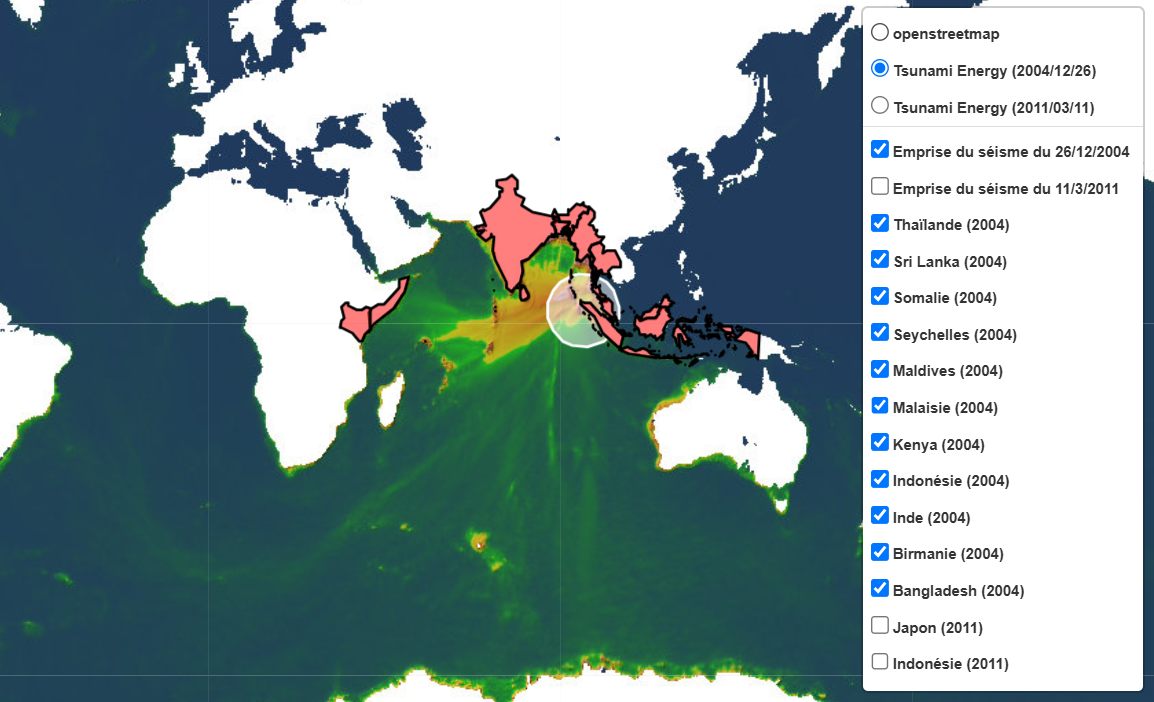